使用resnet50作为主干网络进行训练

In [1]:
import torchvision.models as models

In [21]:
resnet50 = models.resnet50(pretrained=True).cuda()

In [3]:
import torchsummary

In [8]:
torchsummary.summary(resnet50,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [9]:
import torchvision.datasets as datasets
import torchvision
import torch
import numpy as np
import cv2

In [12]:
voc_trainset = datasets.VOCDetection('../../datasets/voc/2012/',year='2012', image_set='train', download=False)

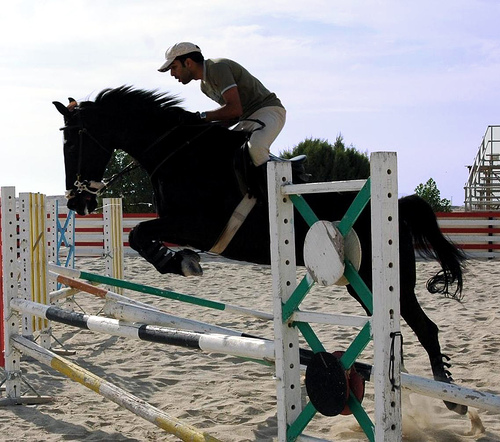

In [14]:
next(iter(voc_trainset))[0]

In [17]:
import PIL

In [18]:
# 图像工具
def draw_voc_image(voc_data: tuple):
    img = voc_data[0]
    canvas = PIL.ImageDraw.ImageDraw(img)
    for obj in voc_data[1]['annotation']['object']:
        left_top = (int(obj['bndbox']['xmin']),int(obj['bndbox']['ymin']))
        right_bottom = (int(obj['bndbox']['xmax']),int(obj['bndbox']['ymax']))
        canvas.rectangle((left_top,right_bottom), fill=None, outline='green', width=1)
        canvas.text(left_top, obj['name'], fill = 'blue')
    return img

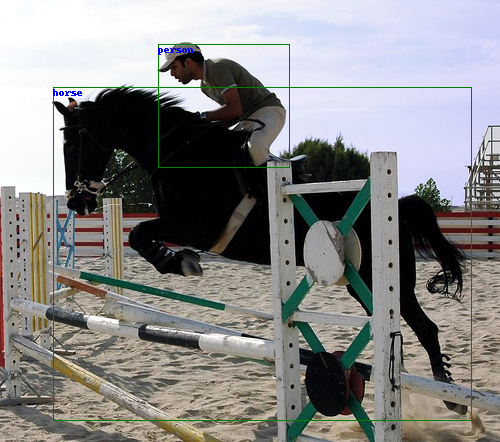

In [19]:
draw_voc_image(next(iter(voc_trainset)))

In [20]:
torchsummary.summary(resnet50,(3,448,448))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           4,096
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 256, 112, 112]          16,384
      BatchNorm2d-12        [-1, 256, 112, 112]             512
           Conv2d-13        [-1, 256, 112, 112]          16,384
      BatchNorm2d-14        [-1, 256, 1

# Resnet50
Resnet50's last several layers:  
<p align='center'>
      <img src="./images/resnet50-last-layers.png">
<p/>

use its backbone without fc

In [43]:
def get_resnet50_backbone():
    features = list(resnet50.children())[:-2]  # remove last 2 layers
    # To reduce the difficulty of training , we only train the last sequential part of layers
    for feature in features[:-1]:
        for parameter in feature.parameters():
            parameter.requires_grad = False
    return torch.nn.Sequential(*features)


In [53]:
class Resnet50Yolo(torch.nn.Module):
    def __init__(self):
        super(Resnet50Yolo, self).__init__()
        self.resnet50_backbone = get_resnet50_backbone()  # output size: 2048x14x14
        self.conv_last = torch.nn.Conv2d(
            2048, 1024, (3, 3), padding=1, stride=2)
        self.fc1 = torch.nn.Linear(50176, 4096)
        self.fc2 = torch.nn.Linear(4096, 1470)

    def forward(self, x):
        x = self.resnet50_backbone(x)
        x = self.conv_last(x)
        x = torch.nn.Flatten()(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [54]:
torchsummary.summary(Resnet50Yolo().cuda(),(3,448,448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           4,096
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 256, 112, 112]          16,384
      BatchNorm2d-12        [-1, 256, 112, 112]             512
           Conv2d-13        [-1, 256, 112, 112]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [ ]:
def yolo_loss(pred: torch.Tensor, truth: torch.Tensor):
    pred = pred.view(-1, 7, 7, 30)
    truth
    pass
